In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import gc


In [4]:
!nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Current using: ',device)

Fri Aug 27 07:36:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.01
MOMENTUM = 0.9
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DOWNLOAD = True

In [6]:
# Transform
transform = transforms.Compose(
                [
                 transforms.Resize(size=(224,224)),
                 transforms.ToTensor(),
                 transforms.Normalize((0.5,), (0.5,)),                 
                #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                 transforms.RandomHorizontalFlip(),
                ]
                )

# Data
train_dataset = datasets.CIFAR10(root='/dataset', train=True, download=DOWNLOAD, transform=transform)
valid_dataset = datasets.CIFAR10(root='/dataset', train=False, download=DOWNLOAD, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /dataset/cifar-10-python.tar.gz to /dataset
Files already downloaded and verified


In [7]:
class basic_block(nn.Module):
    # 輸出通道乘的倍數
    expansion = 1

    def __init__(self, in_channels, out_channels, stride, downsample):
        super(basic_block, self).__init__()      
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 在 shortcut 時，若維度不一樣，要更改維度
        self.downsample = downsample 


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [8]:
class bottleneck_block(nn.Module):
    # 輸出通道乘的倍數
    expansion = 4

    def __init__(self, in_channels, out_channels, stride, downsample):
        super(bottleneck_block, self).__init__()      
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # 在 shortcut 時，若維度不一樣，要更改維度
        self.downsample = downsample 


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, net_block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.net_block_layer(net_block, 64, layers[0])
        self.layer2 = self.net_block_layer(net_block, 128, layers[1], stride=2)
        self.layer3 = self.net_block_layer(net_block, 256, layers[2], stride=2)
        self.layer4 = self.net_block_layer(net_block, 512, layers[3], stride=2)

        self.avgpooling = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * net_block.expansion, num_classes)

        # 參數初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

            elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)        

    def net_block_layer(self, net_block, out_channels, num_blocks, stride=1):
        downsample = None

      # 在 shortcut 時，若維度不一樣，要更改維度
        if stride != 1 or self.in_channels != out_channels * net_block.expansion:
          downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * net_block.expansion, kernel_size=1, stride=stride, bias=False),
                      nn.BatchNorm2d(out_channels * net_block.expansion))

        layers = []
        layers.append(net_block(self.in_channels, out_channels, stride, downsample))
        if net_block.expansion != 1:
          self.in_channels = out_channels * net_block.expansion

        else:
          self.in_channels = out_channels

        for i in range(1, num_blocks):
          layers.append(net_block(self.in_channels, out_channels, 1, None))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpooling(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x

In [10]:
model = ResNet(basic_block, [2, 2, 2, 2], num_classes)
model = model.to(device)
# print(model)
# try:
summary(model, (3,224,224))
# except Exception as e:
#   print(e)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
      basic_block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
def train(epoch):
    print('\nEpoch: %d' % epoch)    
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0            
    for batch_idx, (inputs, targets) in enumerate(train_loader):        
        inputs, targets = inputs.to(device), targets.to(device)
                
        optimizer.zero_grad()        
        outputs = model(inputs)
                
        loss = criterion(outputs, targets)                
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            train_acc_per_epoch = 100 * (correct / float(total))
            train_loss_per_epoch = train_loss / total
            print("Train Epoch: {}/{} [iter： {:03d}/{:03d}], acc： {:.6f}, loss： {:.6f}".format(
               epoch, EPOCH, batch_idx+1, len(train_loader),
               train_acc_per_epoch,
               train_loss_per_epoch))
    return train_acc_per_epoch, train_loss_per_epoch


In [12]:
def test(epoch):        
    model.eval()
    test_loss = 0
    correct = 0
    total = 0    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)            
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 100 == 0:     
              test_acc_per_epoch = 100 * (correct / float(total))
              test_loss_per_epoch = test_loss / total
              print("Valid Epoch: {}/{} [iter： {:03d}/{:03d}], acc： {:.6f}, loss： {:.6f}".format(
                epoch, EPOCH, batch_idx+1, len(valid_loader),                
                test_acc_per_epoch,
                test_loss_per_epoch))                
            
    return test_acc_per_epoch, test_loss_per_epoch

In [13]:
def training_loop():
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(1,EPOCH+1):
        # training
        
        train_acc_, train_loss_ = train(epoch)
        total_train_accuracy.append(train_acc_)
        total_train_loss.append(train_loss_)
        
        valid_acc_, valid_loss_ = test(epoch)        
        total_valid_accuracy.append(valid_acc_)
        total_valid_loss.append(valid_loss_)

        print('==========================================================================')
        print("Epoch: {:05d}/{:05d}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch, EPOCH, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    # print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [14]:
gc.collect()
torch.cuda.empty_cache()

In [15]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop()


Epoch: 1
Train Epoch: 1/10 [iter： 001/782], acc： 15.625000, loss： 0.037352
Train Epoch: 1/10 [iter： 101/782], acc： 27.660891, loss： 0.030804
Train Epoch: 1/10 [iter： 201/782], acc： 31.879664, loss： 0.028961
Train Epoch: 1/10 [iter： 301/782], acc： 35.646802, loss： 0.027370
Train Epoch: 1/10 [iter： 401/782], acc： 38.314370, loss： 0.026243
Train Epoch: 1/10 [iter： 501/782], acc： 40.731038, loss： 0.025224
Train Epoch: 1/10 [iter： 601/782], acc： 42.829659, loss： 0.024335
Train Epoch: 1/10 [iter： 701/782], acc： 44.750802, loss： 0.023573
Valid Epoch: 1/10 [iter： 001/157], acc： 51.562500, loss： 0.019957
Valid Epoch: 1/10 [iter： 101/157], acc： 52.645421, loss： 0.020556
Epoch: 00001/00010， Train acc： 44.750802， Train loss： 0.023573， Valid acc： 52.645421， Valid loss： 0.020556

Epoch: 2
Train Epoch: 2/10 [iter： 001/782], acc： 62.500000, loss： 0.015743
Train Epoch: 2/10 [iter： 101/782], acc： 60.628094, loss： 0.017042
Train Epoch: 2/10 [iter： 201/782], acc： 62.601057, loss： 0.016334
Train Epoch: 2/

In [16]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(1,EPOCH+1), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(1,EPOCH+1), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

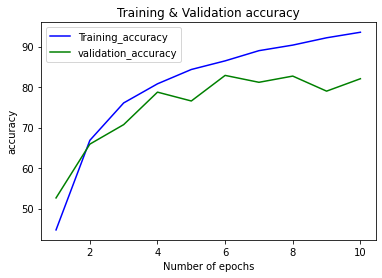

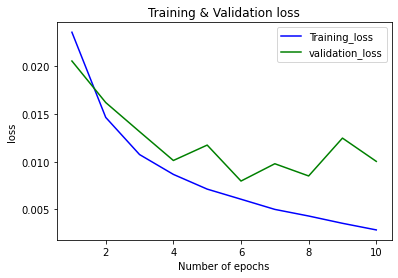

In [17]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')
plot_result(total_train_loss, total_valid_loss, 'loss')